In [1]:
import matplotlib.pyplot as pt
from matplotlib import style
style.use('fivethirtyeight')
import numpy as np 
import pandas as pd
import os
import re
import shutil
import string

In [2]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [3]:
dataset_dir="C:\\Users\\personal\\Desktop\\Tensorflow\\ML basic with keras\\Basic text classification\\aclImdb"

In [4]:
os.listdir(dataset_dir)

['custom', 'imdb.vocab', 'imdbEr.txt', 'README', 'test', 'train']

In [5]:
train_dir=os.path.join(dataset_dir,'train')
train_dir_pos=os.path.join(train_dir,'pos')
train_dir_neg=os.path.join(train_dir,'neg')
os.listdir(train_dir)

['labeledBow.feat',
 'neg',
 'pos',
 'unsupBow.feat',
 'urls_neg.txt',
 'urls_pos.txt',
 'urls_unsup.txt']

In [6]:
def samples(path,filename):
    sample_file=os.path.join(path,filename)
    with open(sample_file) as file:
        print(file.read())

In [7]:
filename=os.listdir(train_dir_pos)[1500]
samples(train_dir_pos,filename)

Steven Rea plays a forensic scientist thrust on the job in Sovie Russia in 1982..in the very first hours of his job a body of a murdered girl is brought in..he has his workers go back to look for evidence and they bring back five more bodies..this starts the story of the hunt for one of the worst serial killers in modern day history..It is a stark depressing dark movie that explores how the bureaucracy of the old Soviet Union indirectly contributed or caused the deaths of many of the killers victims.It also explores in Donald Sutherland's character how the proper usage of bureaucracy in a communist govt can help achieve the ultimate goal of finding a monster A gripping movie not for all but for those who like a good detective story that will hold your interest this is definitely a must see on a scale of one to ten.. 9


In [8]:
filename=os.listdir(train_dir_neg)[0]
samples(train_dir_neg,filename)

Story of a man who has unnatural feelings for a pig. Starts out with a opening scene that is a terrific example of absurd comedy. A formal orchestra audience is turned into an insane, violent mob by the crazy chantings of it's singers. Unfortunately it stays absurd the WHOLE time with no general narrative eventually making it just too off putting. Even those from the era should be turned off. The cryptic dialogue would make Shakespeare seem easy to a third grader. On a technical level it's better than you might think with some good cinematography by future great Vilmos Zsigmond. Future stars Sally Kirkland and Frederic Forrest can be seen briefly.


remove_dir=os.path.join(train_dir,'unsup')
shutil.rmtree(remove_dir)

In [9]:
batch_size=32
seed=42
raw_training_dataset=tf.keras.preprocessing.text_dataset_from_directory('aclImdb/train',
                                                                       batch_size=batch_size,
                                                                       validation_split=0.2,
                                                                       subset='training',
                                                                       seed=seed)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


In [10]:
for text_batch,label_batch in raw_training_dataset.take(1):
    for i in range(5):
        print(f"label is {label_batch.numpy()[i]}")
        print(f"review is {text_batch.numpy()[i]}")

label is 0
review is b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
label is 0
review is b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life chang

In [11]:
print("Label 0 corresponds to ",raw_training_dataset.class_names[0])
print("Label 1 corresponds to ",raw_training_dataset.class_names[1])

Label 0 corresponds to  neg
Label 1 corresponds to  pos


In [12]:
raw_validation_dataset=tf.keras.preprocessing.text_dataset_from_directory('aclImdb/train',
                                                                       batch_size=batch_size,
                                                                       validation_split=0.2,
                                                                       subset='validation',
                                                                       seed=seed)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [13]:
raw_test_dataset=tf.keras.preprocessing.text_dataset_from_directory('aclImdb/test',
                                                                       batch_size=batch_size)

Found 25000 files belonging to 2 classes.


Prepare the dataset for training
Next, you will standardize, tokenize, and vectorize the data using the helpful preprocessing.TextVectorization layer.

Standardization refers to preprocessing the text, typically to remove punctuation or HTML elements to simplify the dataset. Tokenization refers to splitting strings into tokens (for example, splitting a sentence into individual words, by splitting on whitespace). Vectorization refers to converting tokens into numbers so they can be fed into a neural network. All of these tasks can be accomplished with this layer.

As you saw above, the reviews contain various HTML tags like <br />. These tags will not be removed by the default standardizer in the TextVectorization layer (which converts text to lowecase and strips punctuation by default, but doesn't strip HTML). You will write a custom standardization function to remove the HTML.

In [14]:
def custom_standardization(input_data):
    lowercase=tf.strings.lower(input_data)
    stripped_html=tf.strings.regex_replace(lowercase,'<br />',' ')
    return tf.strings.regex_replace(stripped_html,
                                   '[%s]' % re.escape(string.punctuation),
                                   '')

In [15]:
max_features=10000
sequence_length=250

vectorize_layer=TextVectorization(standardize=custom_standardization,
                                 max_tokens=max_features,
                                 output_mode='int',
                                 output_sequence_length=sequence_length)

In [16]:
train_text=raw_training_dataset.map(lambda x,y:x)
vectorize_layer.adapt(train_text)

In [17]:
def vectorize_text(text,label):
    text=tf.expand_dims(text,-1)
    return vectorize_layer(text),label

In [18]:
text_batch,label_batch=next(iter(raw_training_dataset))
first_review,first_label=text_batch[0],label_batch[0]
print("Review",first_review)
print("Label",raw_training_dataset.class_names[first_label])
print("vectorize review")
print(vectorize_text(first_review,first_label))

Review tf.Tensor(b'Silent Night, Deadly Night 5 is the very last of the series, and like part 4, it\'s unrelated to the first three except by title and the fact that it\'s a Christmas-themed horror flick.<br /><br />Except to the oblivious, there\'s some obvious things going on here...Mickey Rooney plays a toymaker named Joe Petto and his creepy son\'s name is Pino. Ring a bell, anyone? Now, a little boy named Derek heard a knock at the door one evening, and opened it to find a present on the doorstep for him. Even though it said "don\'t open till Christmas", he begins to open it anyway but is stopped by his dad, who scolds him and sends him to bed, and opens the gift himself. Inside is a little red ball that sprouts Santa arms and a head, and proceeds to kill dad. Oops, maybe he should have left well-enough alone. Of course Derek is then traumatized by the incident since he watched it from the stairs, but he doesn\'t grow up to be some killer Santa, he just stops talking.<br /><br />T

In [19]:
print("10---->",vectorize_layer.get_vocabulary()[10])
print("100---->",vectorize_layer.get_vocabulary()[100])
print("1000---->",vectorize_layer.get_vocabulary()[1000])
print("Vocabular size -->",len(vectorize_layer.get_vocabulary()))

10----> i
100----> characters
1000----> political
Vocabular size --> 10000


In [20]:
train_dataset=raw_training_dataset.map(vectorize_text)
test_dataset=raw_test_dataset.map(vectorize_text)
valisation_dataset=raw_validation_dataset.map(vectorize_text)

Configure the dataset for performance
These are two important methods you should use when loading data to make sure that I/O does not become blocking.

.cache() keeps data in memory after it's loaded off disk. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache, which is more efficient to read than many small files.

.prefetch() overlaps data preprocessing and model execution while training.

In [21]:
AUTOTUNE=tf.data.experimental.AUTOTUNE
train_dataset=train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
test_dataset=test_dataset.cache().prefetch(buffer_size=AUTOTUNE)
valisation_dataset=valisation_dataset.cache().prefetch(buffer_size=AUTOTUNE)

In [22]:
embedding_dim = 16

In [23]:
model=tf.keras.Sequential([
    layers.Embedding(max_features+1,embedding_dim),
    layers.Dropout(0.2),
    layers.GlobalAveragePooling1D(),
    layers.Dropout(0.2),
    layers.Dense(1)
])

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160016    
_________________________________________________________________
dropout (Dropout)            (None, None, 16)          0         
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
_________________________________________________________________


In [25]:
model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

In [26]:
epochs=10
model.fit(train_dataset,
                 validation_data=valisation_dataset,
                 epochs=epochs)

Epoch 1/10
625/625 [==============================] - 89s 143ms/step - loss: 0.6654 - binary_accuracy: 0.6867 - val_loss: 0.6170 - val_binary_accuracy: 0.7724
Epoch 2/10
625/625 [==============================] - 2s 4ms/step - loss: 0.5510 - binary_accuracy: 0.8006 - val_loss: 0.4997 - val_binary_accuracy: 0.8226
Epoch 3/10
625/625 [==============================] - 2s 3ms/step - loss: 0.4459 - binary_accuracy: 0.8429 - val_loss: 0.4209 - val_binary_accuracy: 0.8464
Epoch 4/10
625/625 [==============================] - 2s 3ms/step - loss: 0.3796 - binary_accuracy: 0.8642 - val_loss: 0.3743 - val_binary_accuracy: 0.8604
Epoch 5/10
625/625 [==============================] - 2s 3ms/step - loss: 0.3361 - binary_accuracy: 0.8781 - val_loss: 0.3454 - val_binary_accuracy: 0.8674
Epoch 6/10
625/625 [==============================] - 2s 3ms/step - loss: 0.3059 - binary_accuracy: 0.8871 - val_loss: 0.3260 - val_binary_accuracy: 0.8712
Epoch 7/10
625/625 [==============================] - 2s 4ms/

In [27]:
loss=pd.DataFrame(model.history.history)
loss.head()

,loss,binary_accuracy,val_loss,val_binary_accuracy
0,0.665362,0.68670,0.616978,0.7724
1,0.551047,0.80060,0.499695,0.8226
2,0.445898,0.84295,0.420943,0.8464
3,0.379636,0.86420,0.374338,0.8604
4,0.336139,0.87805,0.345391,0.8674


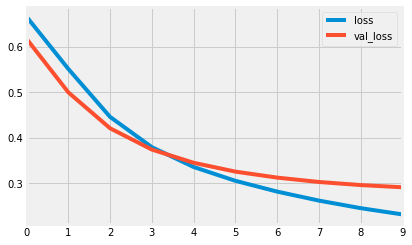

In [28]:
loss[["loss","val_loss"]].plot()

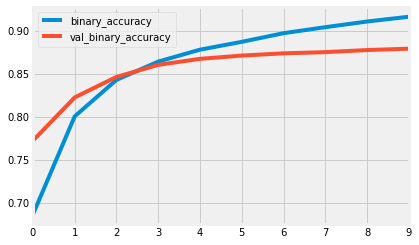

In [29]:
loss[["binary_accuracy","val_binary_accuracy"]].plot()

In [30]:
export_model=tf.keras.Sequential([
    vectorize_layer,
    model,
    layers.Activation('sigmoid')])

In [31]:
export_model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
                    optimizer='adam',metrics=['accuracy'])

In [32]:
loss,accuracy=export_model.evaluate(raw_test_dataset)
print(accuracy)

782/782 [==============================] - 473s 605ms/step - loss: 0.5892 - accuracy: 0.8737
0.8736799955368042


In [33]:
y_pred=export_model.predict_classes(raw_test_dataset)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [34]:
raw_custom_dataset=tf.keras.preprocessing.text_dataset_from_directory('aclImdb/custom')

Found 4 files belonging to 2 classes.


In [35]:
for text_batch,label_batch in raw_custom_dataset.take(1):
    for i in range(4):
        print(f"label is {label_batch.numpy()[i]}")
        print(f"review is {text_batch.numpy()[i]}")

label is 1
review is b'superb,excellent'
label is 0
review is b'very disgusting and annoying'
label is 0
review is b'Very worst movie'
label is 1
review is b'awesome movie'


In [36]:
y_pred_custom=export_model.predict_classes(raw_custom_dataset)

In [37]:
y_pred_custom

array([[1],
       [0],
       [0],
       [1]])

In [38]:
loss,accuracy=export_model.evaluate(raw_custom_dataset)

1/1 [==============================] - 0s 998us/step - loss: 0.6726 - accuracy: 1.0000


In [39]:
print(f"accuracy is {accuracy*100}")

accuracy is 100.0
